# The Method

In [1]:
import numpy as np
import random
import math
import os
import time
from parfor import parfor

from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import gridspec

import pandas as pd
import pickle

In [9]:
import time

class TimerError(Exception):
     """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")

def text_create(path, name, msg):
    full_path = path + "/" + name + '.txt'
    file = open(full_path, 'w')
    file.write(str(msg))


def SVM(X, y):
    model = svm.LinearSVC(max_iter=1000000)
    model.fit(X, y)
    return model


def get_error(model, X, y):
    y_pred = model.predict(X)
    return mean_squared_error(y_pred, y)


def select_samples(X, y, num_samples, sample_selected):
    model = SVM(X, y)
    y_pred = model.predict(X)
    sv = [i for i in range(len(y)) if y[i] != y_pred[i]]
    reused = list(set(sample_selected) & set(sv))
    num_select=num_samples-len(reused)
    if num_select<=0:
        return [],model
    else:
        indices = reused
        sv = list(set(sv) - set(indices))
        if len(sv)<=num_select:
            indices +=sv
        else:
            indices += random.sample(sv, num_select)
    return indices, model


def select_feature(X, y, feature_list):
    coef_ = SVM(X[:, feature_list], y).coef_
    w_padded = np.hstack((coef_, np.zeros((coef_.shape[0], 1))))
    @parfor(range(X.shape[1]),bar=False)
    def angles(i):
        X_local = X[:, feature_list + [i]]
        w_new = SVM(X_local, y).coef_
        cos=cosine_similarity(w_padded, w_new)
        angle = 0
        for j in range(w_padded.shape[0]):
            tmp=cos[j,j]
            if tmp>1:
                tmp=1
            elif tmp<-1:
                tmp=-1
            angle = angle + math.acos(tmp)            
        return angle
    indices = sorted(range(X.shape[1]), key=lambda i: angles[i], reverse=True)
    return [i for i in indices if i not in feature_list][0]


def SVM_active_feature_selection(X_train, y_train, X_test, y_test, num_features, num_samples):
    feature_selected = []
    num_samples_list = []
    samples_global=[]
    train_errors = []
    test_errors = []
    train_scores = []
    test_scores = []

    shuffle = np.arange(X_train.shape[0])
    np.random.shuffle(shuffle)
    samples = shuffle[:num_samples]
    X_global = X_train[samples, :]
    y_global = y_train[samples]
    samples_global=samples
    num_samples_list.append(len(samples_global))

    @parfor(range(X_global.shape[1]),bar=False)
    def scores(i):
        model=SVM(X_global[:,i].reshape(-1, 1),y_global)
        return model.score(X_global[:,i].reshape(-1, 1),y_global)  # R^2 for regression and mean accuracy for classificarion

    new_feature = sorted(range(X_global.shape[1]), key=lambda i: scores[i], reverse=True)[0]
    feature_selected.append(new_feature)

    for i in range(num_features - 1):
        t=Timer()
        t.start()

        X_measured_train = X_train[:,feature_selected]
        X_measured_test = X_test[:,feature_selected]

        samples, model = select_samples(X_measured_train, y_train, num_samples,samples_global)
        samples_global = list(set().union(samples_global, samples))
        num_samples_list.append(len(samples_global))

        train_error = get_error(model, X_measured_train, y_train)
        test_error = get_error(model, X_measured_test, y_test)
        train_score = model.score(X_measured_train, y_train)
        test_score = model.score(X_measured_test, y_test)
        train_errors.append(train_error)
        test_errors.append(test_error)
        train_scores.append(train_score)
        test_scores.append(test_score)
        print("feature " + str(i) + ' : gene ' + str(new_feature)+'  '+str(len(samples_global)) + ' samples')
        print('training error=' + str(train_error) + ' test error=' + str(test_error))
        print('training accuracy=' + str(train_score) + ' test accuracy=' + str(test_score))

        new_feature=select_feature(X_train[samples_global], y_train[samples_global],feature_selected)
        feature_selected.append(new_feature)
        t.stop()

    X_measured_train = X_train[:,feature_selected]
    X_measured_test = X_test[:,feature_selected]
    model=SVM(X_measured_train,y_train)
    train_error = get_error(model, X_measured_train, y_train)
    test_error = get_error(model, X_measured_test, y_test)
    train_score = model.score(X_measured_train, y_train)
    test_score = model.score(X_measured_test, y_test)
    train_errors.append(train_error)
    test_errors.append(test_error)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print("feature " + str(i) + ' : gene ' + str(new_feature)+'  '+str(len(samples_global)) + ' samples')
    print('training error=' + str(train_error) + ' test error=' + str(test_error))
    print('training accuracy=' + str(train_score) + ' test accuracy=' + str(test_score))

    return feature_selected, num_samples_list, samples_global, train_errors, test_errors, train_scores, test_scores




# Download and Load PBMC Data

In [4]:
import urllib.request
import shutil

with urllib.request.urlopen("https://caltech.box.com/shared/static/wqvm0d9irzb7tneb16q01fnr4dt6cvl0.csv") as response, open('./PBMCnorm_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

In [5]:
data_df = pd.read_csv('./PBMCnorm_final.csv')
label_df=pd.read_csv('./labels_final.csv',header = None)
gene_df=pd.read_csv('./genes_final.csv')
classes=[0,1,2,3,4]
keys=['Monocytes','T cells','Act. T/NK','B cells','Others']

raw_data=data_df.values
target=label_df.values.reshape((raw_data.shape[1],)).astype(np.uint8)-1
gene=gene_df.values.reshape((raw_data.shape[0],))
data=normalize(np.transpose(raw_data),axis=1, norm='l2')
del data_df,label_df,gene_df,raw_data


idx = np.arange(np.shape(data)[0])
random.shuffle(idx)
X_train = data[idx[:int(np.shape(data)[0]*4/5)],:]
y_train = target[idx[:int(np.shape(data)[0]*4/5)]]
X_test = data[idx[int(np.shape(data)[0]*4/5):],:]
y_test = target[idx[int(np.shape(data)[0]*4/5):]]

print(type(data))
print(np.shape(data),np.shape(target),len(np.unique(target)))
print(np.shape(X_train))
print(np.shape(X_test))
for i in np.unique(target):
    print('class '+keys[i]+': '+str(np.count_nonzero((target==i)*1)))

<class 'numpy.ndarray'>
(10194, 6915) (10194,) 5
(8155, 6915)
(2039, 6915)
class Monocytes: 3269
class T cells: 3517
class Act. T/NK: 1265
class B cells: 995
class Others: 1148


# Define Parameters and Work Space

In [7]:
'''
Parameters
----------
balance : boolean
    balance the number of cells of each class or just randomly select cells at each loop
num_features : int
    the total number of genes we want to select 
num_samples : int
    the number of cells we would use at each loop
'''
num_features = 50
num_samples=100

folder='results'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Creation of the directory results/test_50_100 failed


# Select Genes and Save Results

feature 0 : gene 452  155 samples
training error=2.1281422440220723 test error=2.090240313879353
training accuracy=0.567504598405886 test accuracy=0.5571358509073076
Elapsed time: 91.4935 seconds
feature 1 : gene 2232  188 samples
training error=1.8039239730226855 test error=1.7130946542422756
training accuracy=0.7012875536480687 test accuracy=0.7042667974497303
Elapsed time: 130.2764 seconds
feature 2 : gene 2230  190 samples
training error=1.7610055180870632 test error=1.6890632663070133
training accuracy=0.7124463519313304 test accuracy=0.7121137812653261
Elapsed time: 135.1630 seconds
feature 3 : gene 870  222 samples
training error=1.6242795830778662 test error=1.5443845022069642
training accuracy=0.7919068056407113 test accuracy=0.7969592937714566
Elapsed time: 124.4797 seconds
feature 4 : gene 1829  225 samples
training error=1.6333537706928265 test error=1.5056400196174595
training accuracy=0.7963212752912324 test accuracy=0.8008827856792545
Elapsed time: 131.5489 seconds
featu

Elapsed time: 175.4887 seconds
feature 42 : gene 129  300 samples
training error=0.9769466584917229 test error=0.9651790093182933
training accuracy=0.8918454935622318 test accuracy=0.8940657184894556
Elapsed time: 182.9319 seconds
feature 43 : gene 4488  300 samples
training error=0.9733905579399141 test error=0.9691025012260912
training accuracy=0.8925812385039853 test accuracy=0.8940657184894556
Elapsed time: 179.9038 seconds
feature 44 : gene 919  301 samples
training error=0.9648068669527897 test error=0.9475232957332026
training accuracy=0.8929491109748621 test accuracy=0.8955370279548799
Elapsed time: 173.6549 seconds
feature 45 : gene 181  301 samples
training error=0.9419987737584304 test error=0.9455615497793036
training accuracy=0.8947884733292458 test accuracy=0.8960274644433546
Elapsed time: 173.7385 seconds
feature 46 : gene 6679  301 samples
training error=0.9386879215205396 test error=0.9259440902403139
training accuracy=0.8956468424279583 test accuracy=0.896517900931829

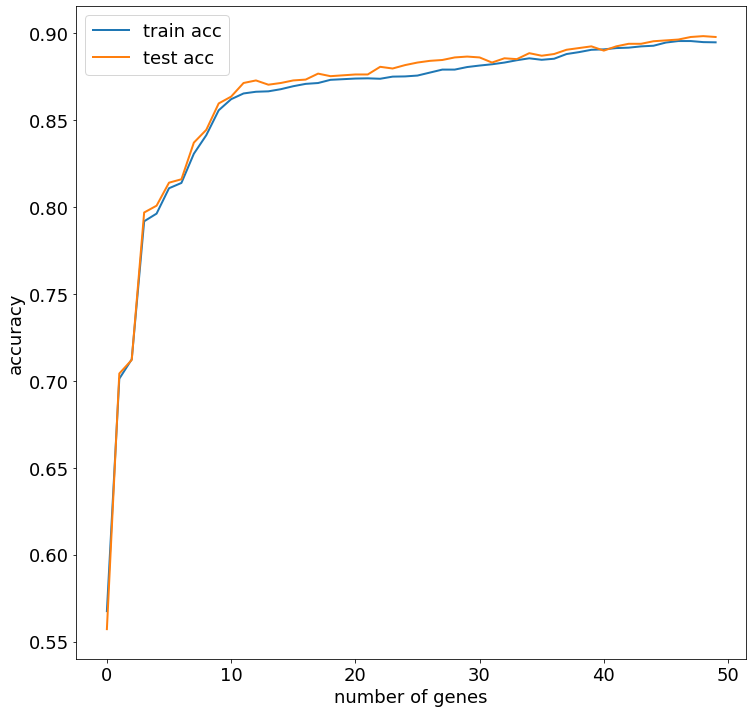

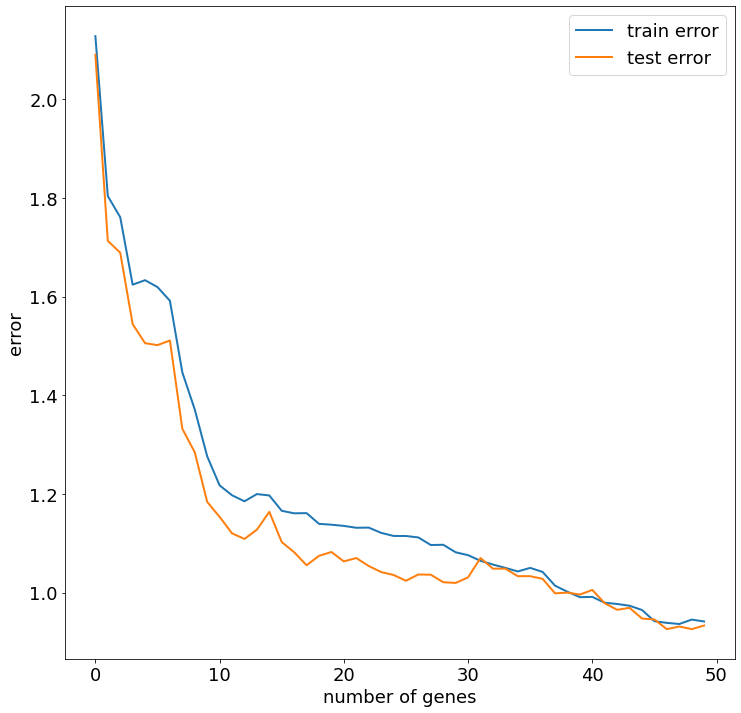

In [10]:
if __name__ == '__main__':
    feature_selected, num_samples_list, samples_global, train_errors,test_errors,train_scores,test_scores= SVM_active_feature_selection(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples)



    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'samples_global',samples_global)
    text_create(path,'genes_name',gene[feature_selected])

    plt.figure(figsize=(12,12))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

    plt.figure(figsize=(12,12))
    plt.plot(train_errors,linewidth=2)
    plt.plot(test_errors,linewidth=2)
    plt.legend(['train error','test error'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('error',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/error.pdf', bbox_inches="tight")

# T-SNE of Results

## T-SNE of Original Dataset

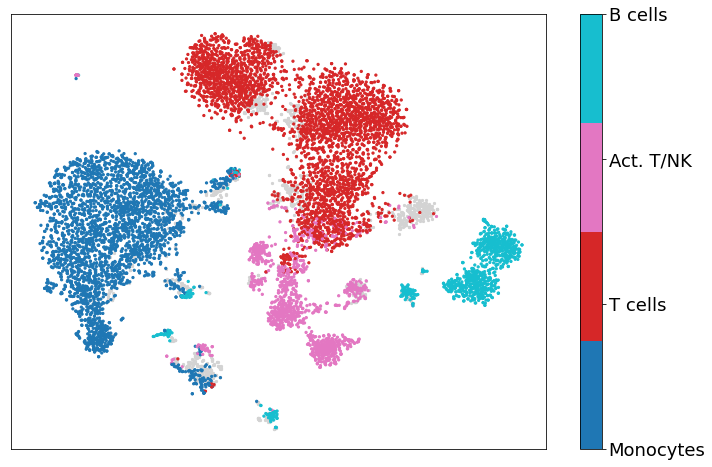

In [11]:
plt.figure(figsize=(12,8))

pca=PCA(n_components=int(X_train.shape[1]/100),
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data)

Y=TSNE(n_components=2).fit_transform(pcaproj)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y[others,0], Y[others,1], c='lightgray', s=5)
plt.scatter(Y[cells,0],Y[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne.pdf',bbox_inches="tight")

f=open(path+'/tsne.pickle','wb') 
pickle.dump(Y,f)
f.close()

## T-SNE with All Genes Selected

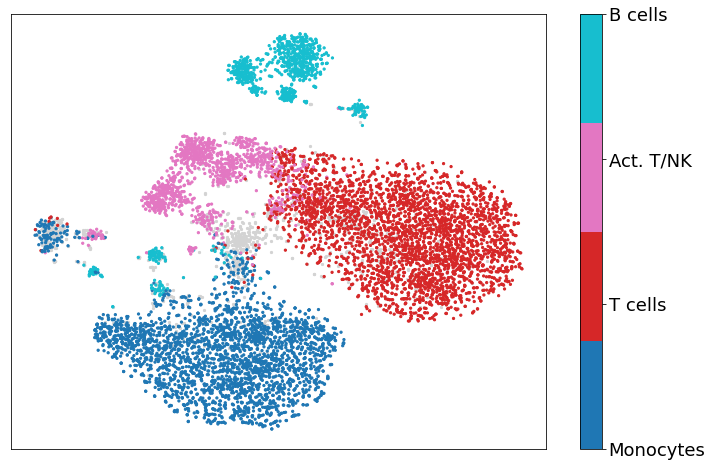

In [12]:
plt.figure(figsize=(12,8))
data_selected=data[:,feature_selected]

Y_selected=TSNE(n_components=2).fit_transform(data_selected)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y_selected[others,0], Y_selected[others,1], c='lightgray', s=5)
plt.scatter(Y_selected[cells,0],Y_selected[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne_selected_woPCA.pdf',bbox_inches="tight")

f=open(path+'/tsne_selected_woPCA.pickle','wb') 
pickle.dump(Y_selected,f)
f.close()

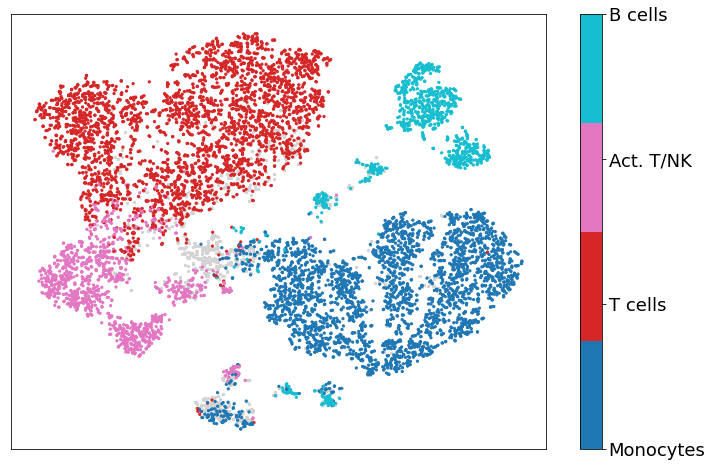

In [13]:
plt.figure(figsize=(12,8))
data_selected=data[:,feature_selected]

pca=PCA(n_components=int(num_features/5),
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data_selected)

Y_selected=TSNE(n_components=2).fit_transform(pcaproj)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y_selected[others,0], Y_selected[others,1], c='lightgray', s=5)
plt.scatter(Y_selected[cells,0],Y_selected[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne_selected_wPCA.pdf',bbox_inches="tight")

f=open(path+'/tsne_selected_wPCA.pickle','wb') 
pickle.dump(Y_selected,f)
f.close()

## T-SNE of Each Gene

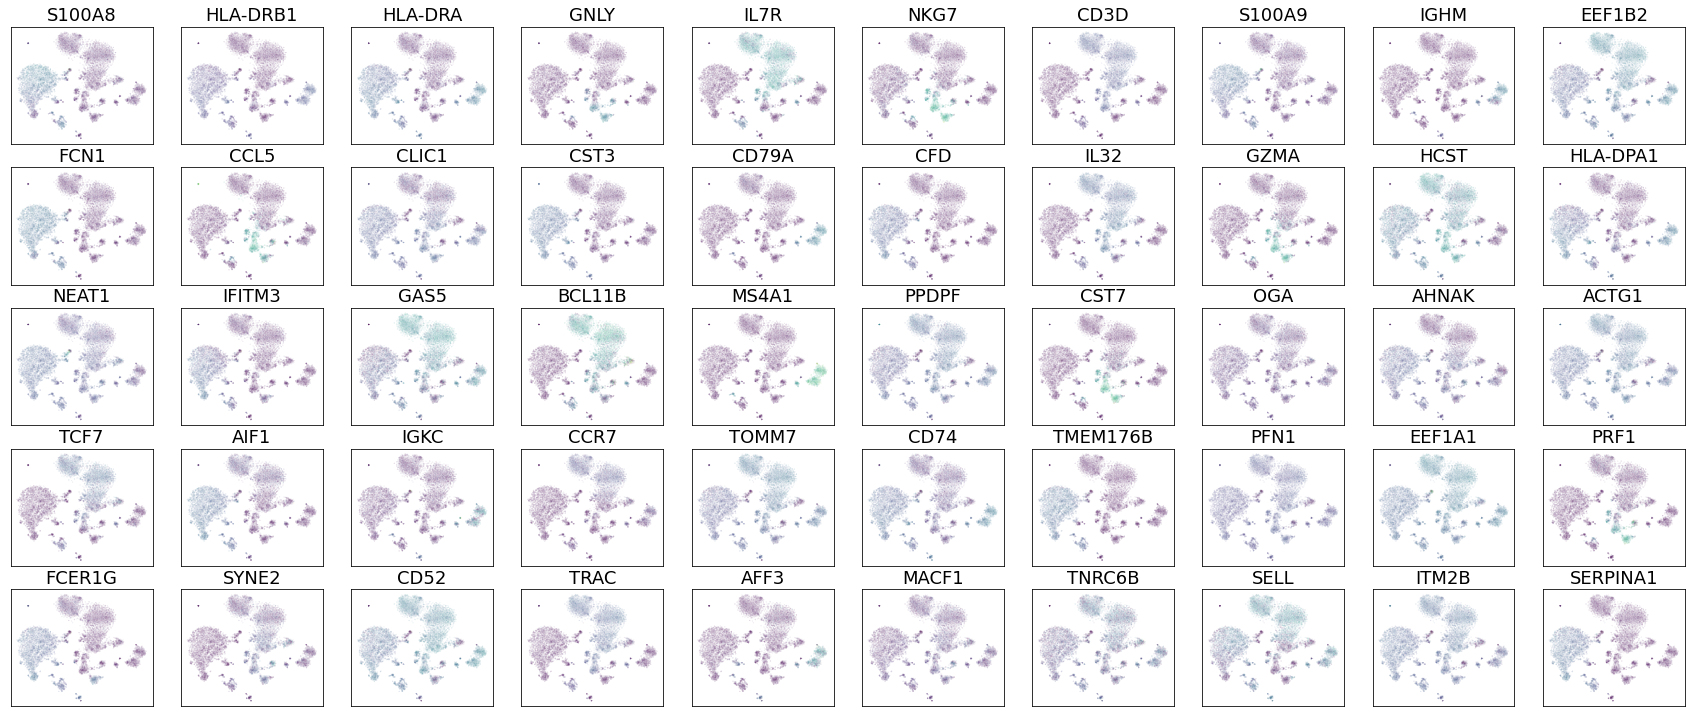

In [16]:
size=len(feature_selected)
plt.figure(figsize=(30,12.5))
gs = gridspec.GridSpec(5, 10, width_ratios=[7,7,7,7,7,7,7,7,7,7])

for i in range(size):
    f=feature_selected[i]
    ax0 = plt.subplot(gs[i])
    ax0.set_title(gene[f],fontdict={'weight':'normal','size': 18})
    plt.scatter(Y[:,0],Y[:,1],c=data[:,f],s=0.001)
    ax0.set_xticks([])
    ax0.set_yticks([])
plt.savefig(path+'/gene.png',dpi=300,  bbox_inches="tight")    